# Обучение с учителем модели персонализации.

### Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Один из возможных вариантов удержания активности - удерживание активности постоянных клиентов.

### Цель проекта

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from IPython.display import display
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

#!pip install phik -q
#!pip install yellowbrick
#!pip install shap
#!pip install scikit-learn==1.1.3 -q
#!pip install matplotlib==3.5.2 -q
import phik
from phik import phik_matrix

TEST_SIZE = 0.25
RANDOM_STATE = 42

# импортирую отдельно части sklearn, чтобы не путаться лишний раз
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    roc_auc_score
)


from yellowbrick.classifier.rocauc import (
    roc_auc
)

from sklearn.inspection import permutation_importance
import shap

## Загрузка данных

In [2]:
m_file_df = pd.read_csv('/datasets/market_file.csv')
m_money_df = pd.read_csv('/datasets/market_money.csv')
m_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

In [3]:
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [4]:
data_info(m_file_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Пропусков в датафрейме:  id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [5]:
data_info(m_money_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Пропусков в датафрейме:  id         0
Период     0
Выручка    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [6]:
data_info(m_time_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Пропусков в датафрейме:  id        0
Период    0
минут     0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [7]:
data_info(money_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Пропусков в датафрейме:  id         0
Прибыль    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


### Промежуточный вывод по загрузке данных

Обнаружено:

* m_file_df: явных дубликатов не обнаружено, средние значения не сильно отличаются от медианных, значит количество выбросов мало, столбцы начинаются с верхнего регистра, у категориальных столбцов тип данных object, пропусков нет
- m_money_df: дубликатов нет, пропусков нет, столбцы начинаются с верхнего регистра аналогично, тип данных у столбцов object
- m_time_df: дубликатов нет, пропусков нет, есть столбец в верхнем регистре, есть опечатка в признаках
- money_df: дубликатов нет, пропусков нет, столбец в верхнем регистре
- данные соответствуют описанию

Что будет обработано:

Столбцы во всех датафреймах будут приведены к нижнему регистру, для оптимизации столбцы object будут преобразованы в category. Столбец "минут" в m_time_df будет переименован в "минуты".

##  Предобработка данных

In [8]:
# преобразуем названия столбцов к нижнему регистру
m_file_df.columns= m_file_df.columns.str.lower()
m_money_df.columns= m_money_df.columns.str.lower()
m_time_df.columns = m_time_df.columns.str.lower()
money_df.columns= money_df.columns.str.lower()

In [9]:
# теперь поработаем с типами столбцов, преобразуем все в category
cols_m_file = ['покупательская активность', 'тип сервиса','разрешить сообщать','популярная_категория', 'маркет_актив_тек_мес']
for col in cols_m_file:
    m_file_df[col] = m_file_df[col].astype('category')

m_money_df['период'] = m_money_df['период'].astype('category')
# внесем исправления опечаток
m_file_df['тип сервиса']= m_file_df['тип сервиса'].replace('стандартт', 'стандарт')
m_time_df= m_time_df.rename(columns={'минут': 'минуты'})
m_time_df['период'] = m_time_df['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

### Проведем исследовательский анализ

Для этого построим графики распределения признаков.

In [10]:
m_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская активность            1300 non-null   category
 2   тип сервиса                          1300 non-null   category
 3   разрешить сообщать                   1300 non-null   category
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   category
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [11]:
num_col1=['маркет_актив_6_мес',  'длительность', 'акционные_покупки','средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']


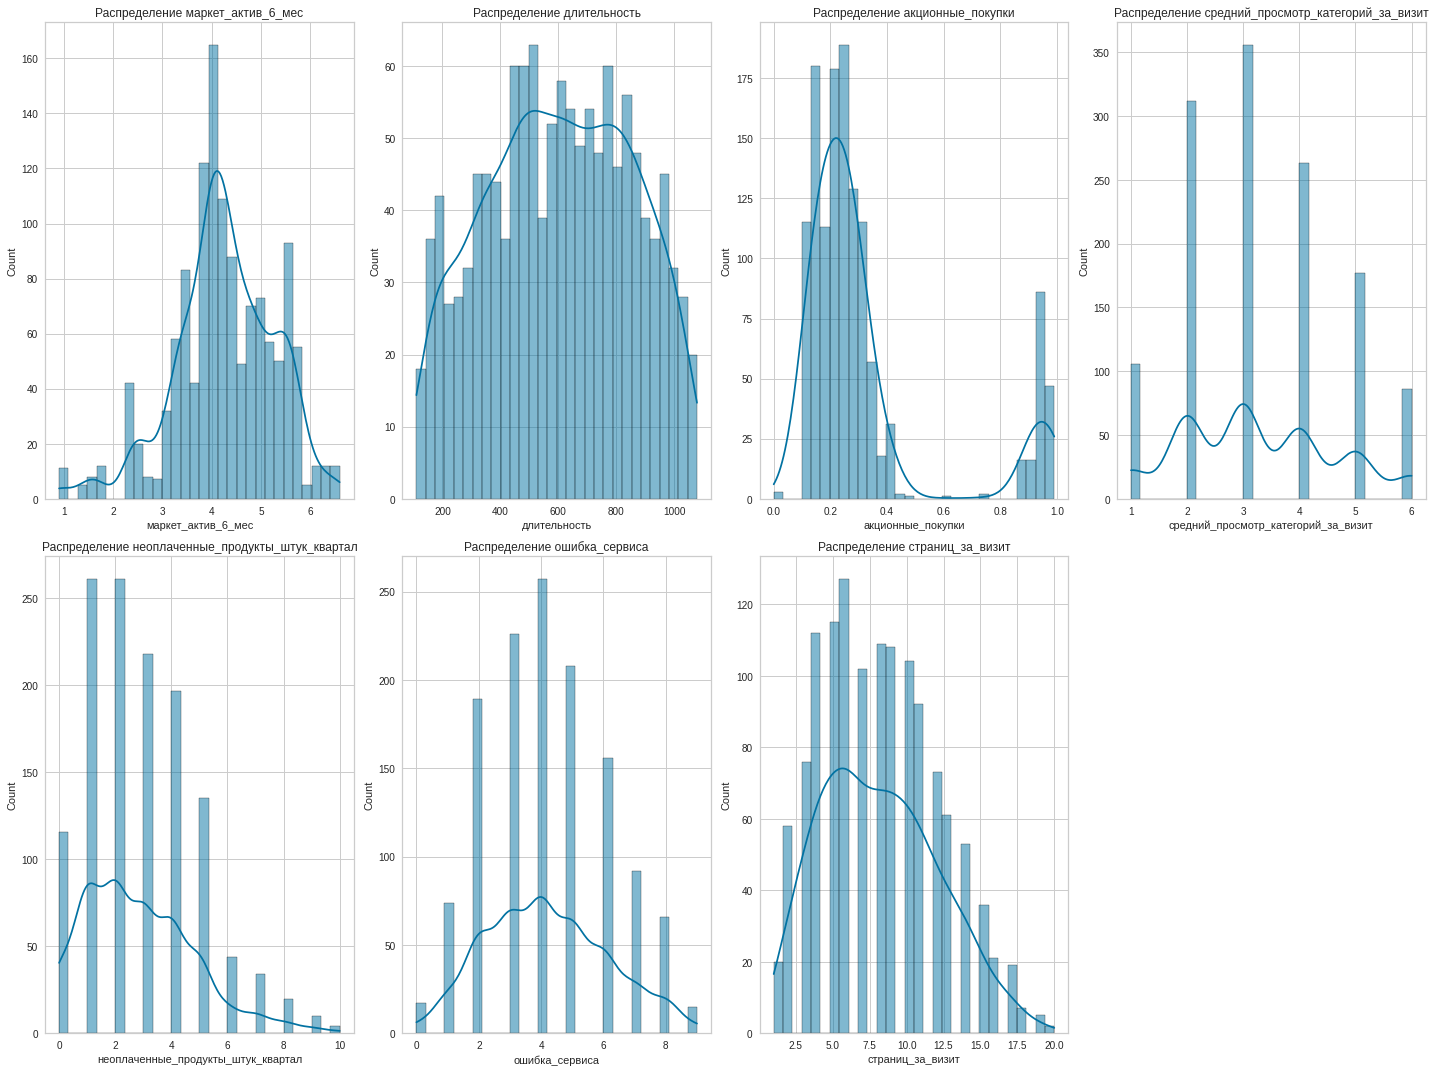

In [12]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col1, 1):
    plt.subplot(2, 4, i)
    sns.histplot(m_file_df[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

Также посмотрим боксплот.

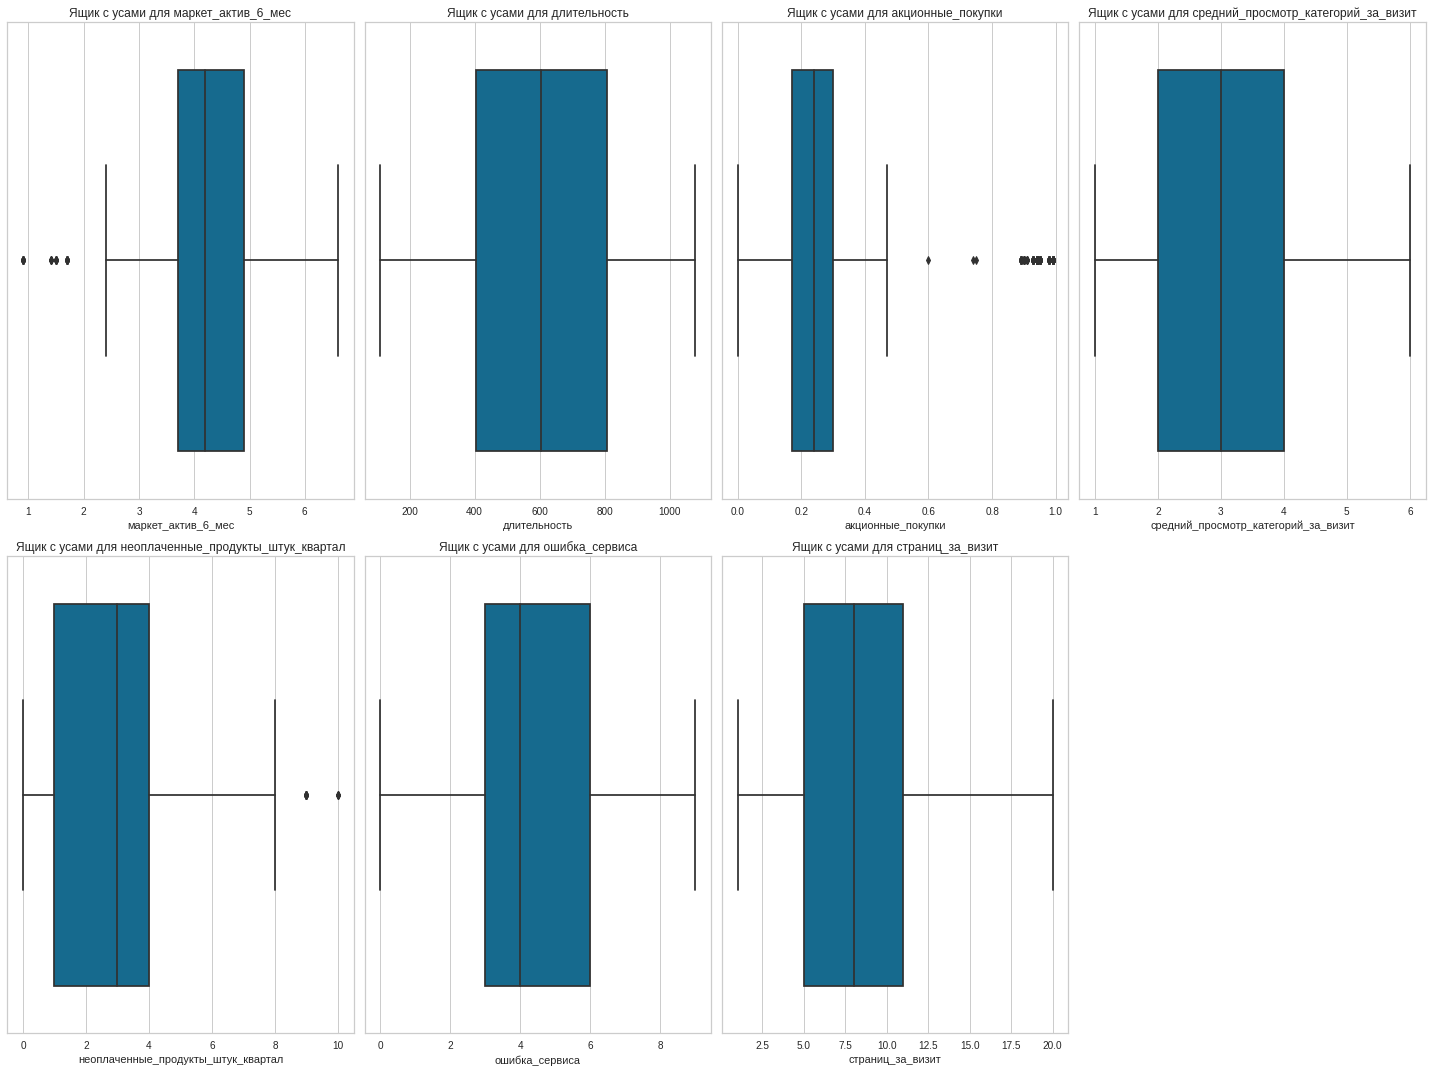

In [13]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col1, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=m_file_df[col])
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='выручка', ylabel='Count'>

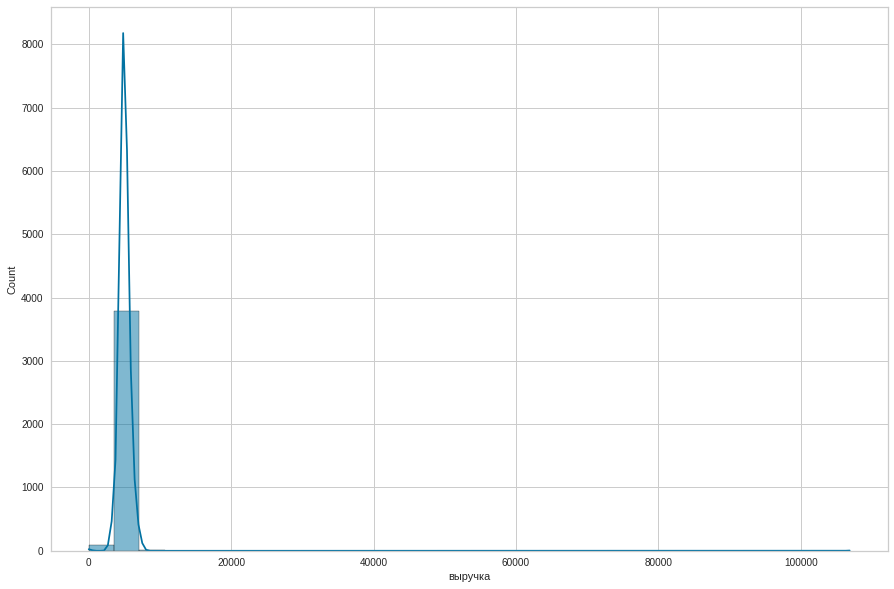

In [14]:
plt.figure(figsize=(15, 10))
sns.histplot(m_money_df['выручка'], kde=True, bins=30)

Наблюдаем выбросы по выручке, разбираемся и удаляем.

In [15]:
outlier_users = m_money_df.loc[(m_money_df['выручка'] > 10000) | (m_money_df['выручка'] < 10)]['id'].unique().tolist()
outlier_users

[215348, 215357, 215359, 215380]

In [16]:
#Удалим выбросы по выручке и удалим все связанные с этими пользователями записи
# из других датасетов если они есть.
m_file_df.drop(m_file_df[m_file_df['id'].isin(outlier_users)].index, inplace=True)
m_time_df.drop(m_time_df[m_time_df['id'].isin(outlier_users)].index, inplace=True)
m_money_df.drop(m_money_df[m_money_df['id'].isin(outlier_users)].index, inplace=True)
money_df.drop(money_df[money_df['id'].isin(outlier_users)].index, inplace=True)


Теперь посмотрим на распределение данных после удаления. Выбросы удалены и распределение похоже на нормальное.

<AxesSubplot:xlabel='выручка', ylabel='Count'>

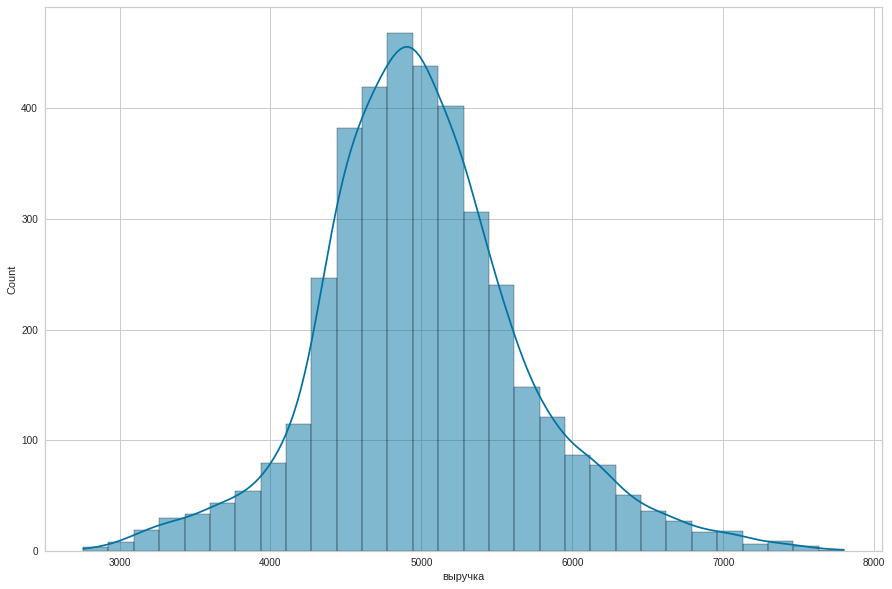

In [17]:
plt.figure(figsize=(15, 10))
sns.histplot(m_money_df['выручка'], kde=True, bins=30)

### Промежуточный вывод по числовым признакам

* маркет_актив_6_мес. Содержит среднемесячное значение маркетинговых коммуникаций компании
- маркет_актив_тек_мес. Это поле содержит информацию о количестве маркетинговых коммуникаций в текущем месяце.
- акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Теперь проанализируем категориальные признаки

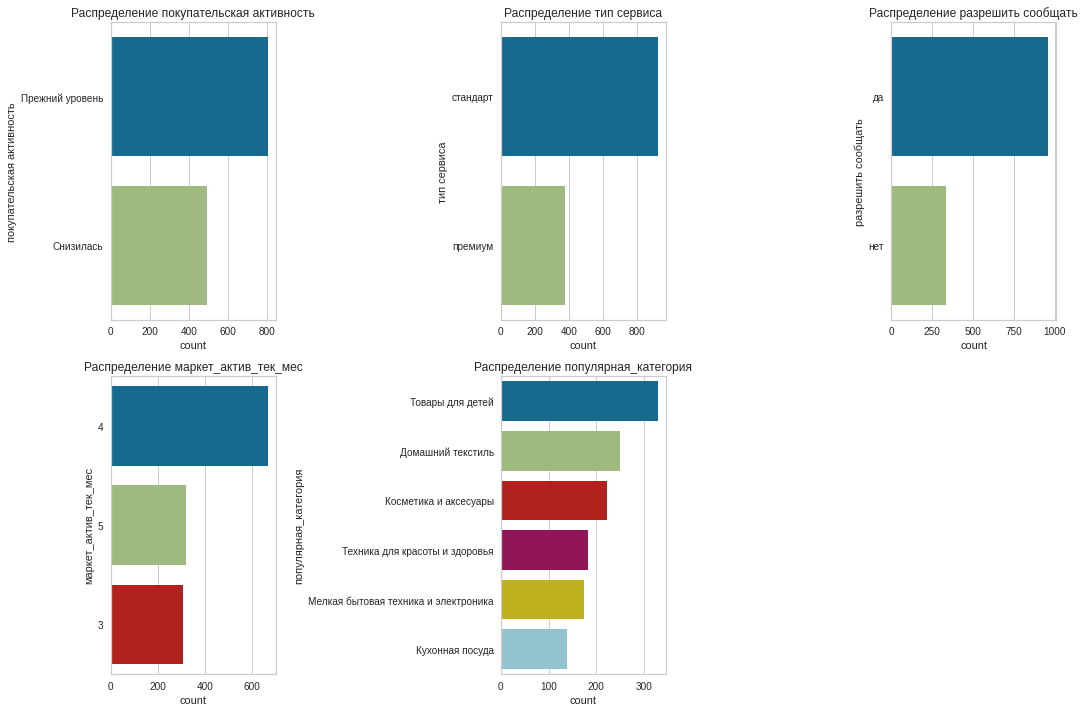

In [18]:
categorical_columns1 = ['покупательская активность', 'тип сервиса','разрешить сообщать', 'маркет_актив_тек_мес','популярная_категория']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns1, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=m_file_df[col], order=m_file_df[col].value_counts().index)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

### Промежуточный вывод по категориальным признакам

С ними все нормально. Единственное, наблюдается высокая разница в количестве признаков. Так, например, в распределении по типу сервиса, "стандарт" больше "премиум" пользователей более чем в 2 раза. При обучении моделей нужно будет применить сэмплирование.


### Отбор пользователей, совершивших покупки в последнее время.

Теперь выделим клиентов с покупательской активностью не менее трёх месяцев, то есть тех, кто совершал покупки в течение этого периода. Для этого обратимся к датасету m_money_df и найдём идентификаторы пользователей, у которых выручка не равна нулю. Таким образом, мы отфильтруем тех, кто совершал покупки, исключив пользователей с нулевой выручкой.

In [19]:
not_active_users = m_money_df.groupby('id').prod().query('выручка == 0')
not_active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   выручка  0 non-null      float64
dtypes: float64(1)
memory usage: 0.0 bytes


### Промежуточный вывод

Внезапно получилось, что вместе с выбросами были удалены неактивные пользователи.

Перед началом корелляционного анализа объединим часть таблиц. Посмотрим на их размерность.

In [20]:
print(f'm_file_df: {m_file_df.shape}')
print(f'm_money_df: {m_money_df.shape}')
print(f'm_time_df: {m_time_df.shape}')

m_file_df: (1296, 13)
m_money_df: (3888, 3)
m_time_df: (2592, 3)


In [21]:
# теперь сгрупируем таблицы m_money_df и m_time_df по периоду:
m_time_grouped_df = m_time_df.set_index(['id', 'период']).минуты.unstack().add_prefix('минут_')
m_time_grouped_df.head()

период,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [22]:
m_money_grouped_df = m_money_df.set_index(['id', 'период']).выручка.unstack().add_prefix('выручка_')
m_money_grouped_df.head()

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [23]:
# и наконец объединим с m_file_df
market_df_full = m_file_df.join(
    m_time_grouped_df, on='id', how='left'
).join(
    m_money_grouped_df, on='id', how='left'
)
market_df_full.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


In [24]:
print(f'm_file_df: {m_file_df.shape}')
print(f'm_money_grouped_df: {m_money_grouped_df.shape}')
print(f'm_time_grouped_df: {m_time_grouped_df.shape}')
print(f'market_df_full: {market_df_full.shape}')

m_file_df: (1296, 13)
m_money_grouped_df: (1296, 3)
m_time_grouped_df: (1296, 2)
market_df_full: (1296, 18)


In [25]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})

# Функция для построения графиков
def plot_distributions(df, num_cols, target_col='покупательская активность'):

    # Определяем количество строк для сетки
    n_rows = len(num_cols)
    
    # Создаем фигуру и оси
    fig, axes = plt.subplots(n_rows, 2, figsize=(20, 6 * n_rows))
    fig.tight_layout(pad=5.0)
    
    # Построение графиков для числовых признаков
    for i, col in enumerate(num_cols):
        # Гистограмма
        sns.histplot(data=df, x=col, hue=target_col, kde=True, palette='viridis', alpha=0.6, ax=axes[i, 0])
        axes[i, 0].set_title(f'Распределение {col} в разрезе {target_col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Частота')
        
        # Боксплот
        sns.boxplot(data=df, x=target_col, y=col, palette='viridis', ax=axes[i, 1])
        axes[i, 1].set_title(f'Боксплот {col} в разрезе {target_col}')
        axes[i, 1].set_xlabel(target_col)
        axes[i, 1].set_ylabel(col)
    
    plt.show()

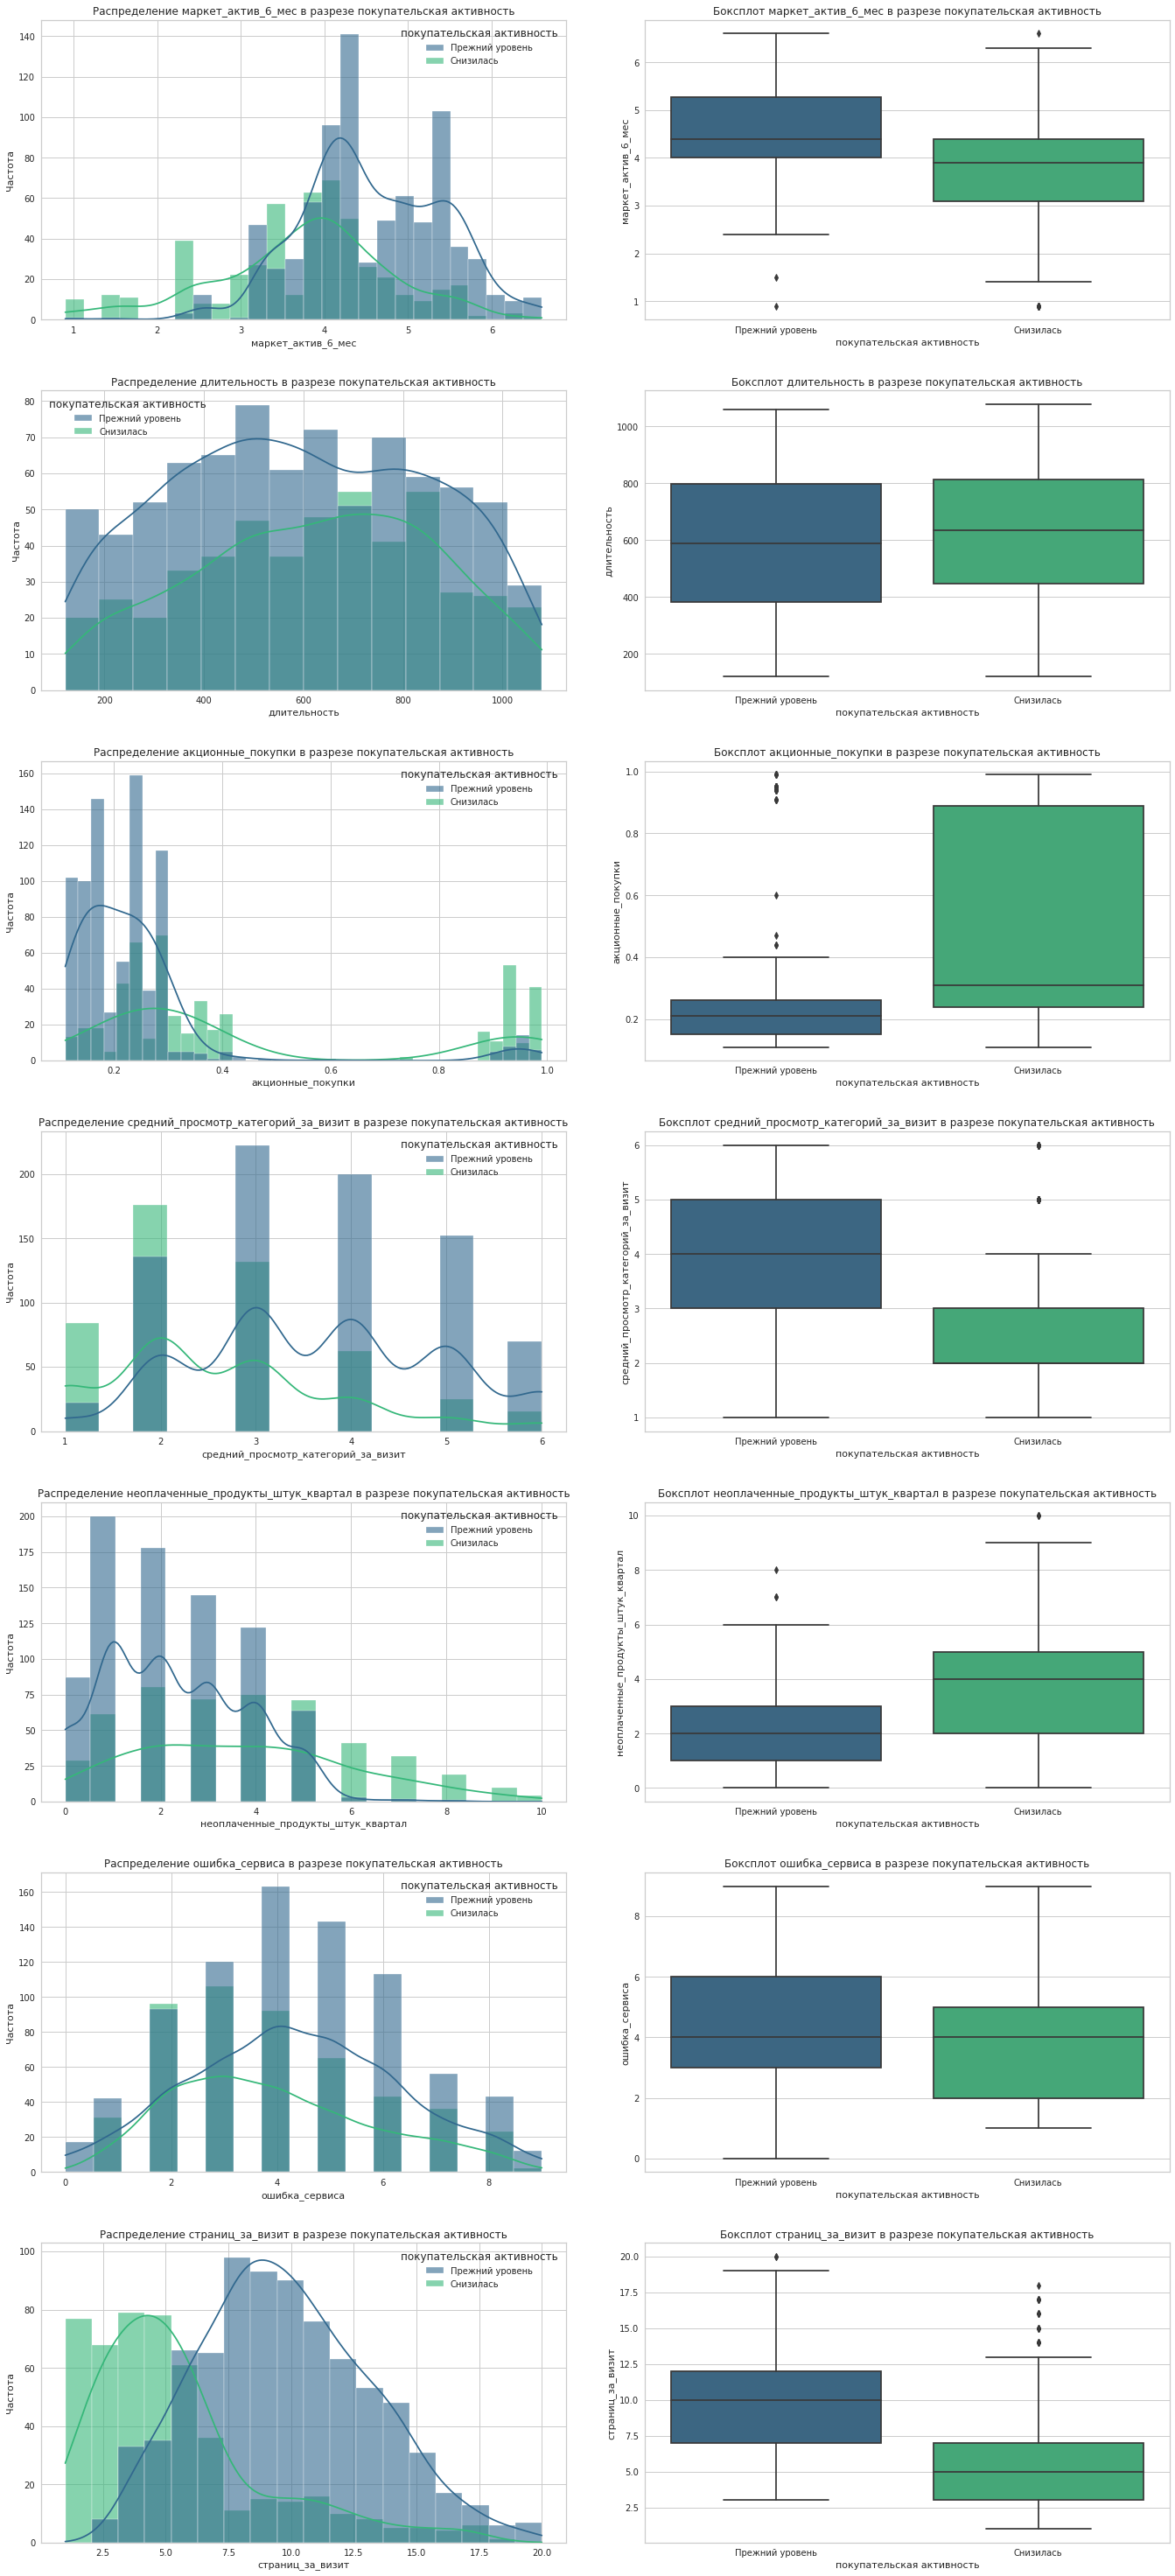

In [26]:
plot_distributions(market_df_full.drop(columns=['id'], axis=1), num_col1)

### Промежуточный вывод

В процессе объединения таблиц был создан единый датасет для работы с информацией о пользователях на сайте.

### Вывод по EDA

Мы выполнили поставленную задачу EDA. Нами были улучшенны показатели данных, и объеденены таблицы согласно поставленной задаче. В финальном датасете наблюдается не нормальное распределение данных. Которое требует более детального изучения на этапе кореляционного анализа.

Мы видим ,что покупательская активность довольно сильно зависит от маркетинга. Отчетливо видно, что среди участников акционных программ, в целом наблюдается снижение активности
видно что количество неоплаченных продуктов влечет снижение покупательской активности. Чем больше неоплаченых продуктов тем выше показатель снижения
видна зависимость между снижением активности и колличеством просмотренных страниц. Чем ниже страниц просматривалось тем сильнее снижение активности
Видим увеличение пользователей у которых снизилась покупательская активность, посетивших категории Кухонная посуда, товары для здоровья и товары для детей

## Корелляционный анализ

Для создания эффективной модели линейной регресии нам необходимо наличие умеренной зависимости между признаками и отсутствие мультиколлинеарности, то есть зависимости больше чем 0.9. Так как признаки распределены ненормально, воспользуемся рассчетом коэффициентов по Спирману. Воспользуемся библиотекой phik.

In [27]:
interval_cols = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц'
]

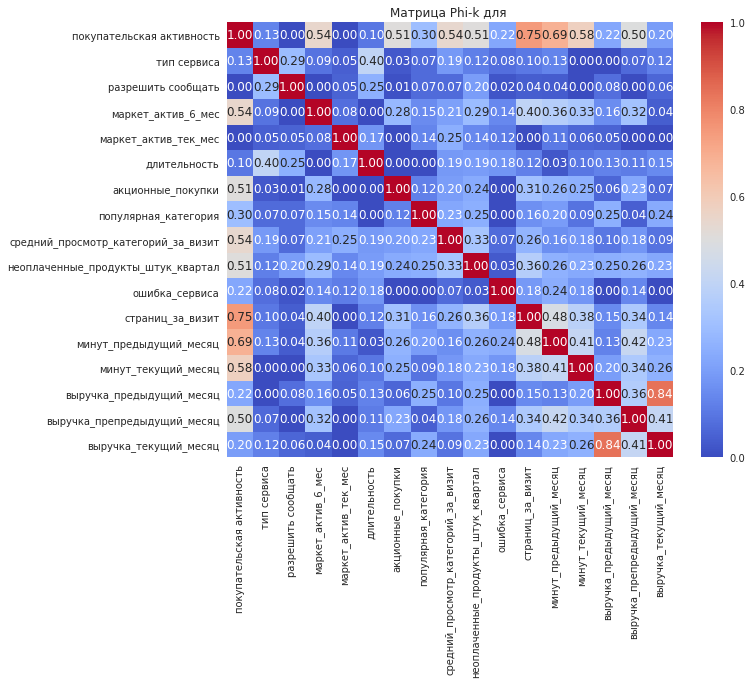

In [28]:
# собираем матрицу корелляции
plt.figure(figsize=(10, 8))
phik_corr_matrix = market_df_full.drop('id', axis=1).phik_matrix(interval_cols)

#закоментированный вариант выводит матрицу без id, но там другие коэффициенты
# какой вариант лучше использовать?
#phik_corr_matrix = market_df_full[interval_cols].phik_matrix()
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица Phi-k для ')
plt.show()

### Промежуточный вывод

По данным матрицы корелляции можно сделать вывод, что мультиколлинеарности не наблюдается. Перейдем к использованию пайплайнов.

## Использование пайплайнов

Для начала разберемся, как нужно преобразовать столбцы датафрейма market_df_full.

In [29]:
market_df_full.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


Удалить:
* id

Оhe-категоризация:
* тип_сервиса, разрешить сообщать

Оrd-категоризация:
* популярная категория

Масштабировать:
* маркет_актив_6
_мес
- маркет_актив_тек_мес
- длительность
- акционные_покупки
- средний_просмотр_категорий_за_визит
- неоплаченные_продукты_штук_квартал
- ошибка_сервиса
- страниц_за_визит
- минут_текущий_месяц
- минут_предыдущий_месяц
- выручка_препредыдущий_месяц
- выручка_текущий_месяц
- выручка_предыдущий_месяц

Целевой столбец:
* "покупательская активность" преобразовать в бинарный

In [30]:
#добавим колонки в новые листы для пайплайнов
ohe_columns = ['тип сервиса',
               'разрешить сообщать']

ord_columns = ['популярная_категория']

num_columns = [ 'маркет_актив_6_мес',
                'маркет_актив_тек_мес',
                'длительность',
                'акционные_покупки',
                'средний_просмотр_категорий_за_визит',
                'неоплаченные_продукты_штук_квартал',
                'ошибка_сервиса',
                'страниц_за_визит',
                'минут_текущий_месяц',
                'минут_предыдущий_месяц',
                'выручка_препредыдущий_месяц',
                'выручка_текущий_месяц',
                'выручка_предыдущий_месяц']

target_column = 'покупательская активность'
bin_fact= {'Прежний уровень':0,
            'Снизилась':1}
market_df_full['покупательская активность']= market_df_full['покупательская активность'].map(bin_fact)
market_df_full['покупательская активность'] = market_df_full['покупательская активность'].astype('int')

In [31]:
#подготовим данные
X_train, X_test, y_train, y_test = train_test_split(
    market_df_full.drop(['id',
                     'покупательская активность'
                    ], axis=1).reset_index(drop=True),
    market_df_full['покупательская активность'],
    test_size    = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify     = market_df_full['покупательская активность']
)

In [32]:
# шаг 1
# Создадим пайплайн для подготовки признаков из ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan,strategy='most_frequent')        
        ),
        (
            'ohe',
            OneHotEncoder(drop='first')
        )
    ]
)

# шаг 2
# Создадим пайплайн для подготовки признаков из ord_columns
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_ord_befoure',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['Товары для детей', 
                    'Домашний текстиль', 
                    'Косметика и аксесуары',
                    'Техника для красоты и здоровья', 
                    'Кухонная посуда',
                    'Мелкая бытовая техника и электроника']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'SimpleImputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

#шаг 3
# Создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe,        ohe_columns),
        ('ord', ord_pipe,        ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

#шаг 4
# Создаем итоговый пайплайн для подготовки данных и моделирования
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[SVC(random_state=RANDOM_STATE)],
        'preporcessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[LogisticRegression(random_state = RANDOM_STATE,
                                     solver       = 'liblinear',
                                     penalty      = 'l1'
                                    )
                 ],
        'models__C': range(1,5),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# Для анализа качества модели будем использовать метрику roc_auc, потому что ана учитывает работу модели при всех 
# возможных значениях порогов и поэтому не зависит от одного конкретного. 
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv           = 5,
    scoring      = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs       = -1
)

# обучаем модель на тренировочной выборке
randomized_search.fit(X_train, y_train)

# сразу получим лучшую модель, параметры, метрику
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['тип сервиса',
                                                   'разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleImputer_ord_befoure',
                                                                   SimpleImputer(strategy='most_frequent')),
                                             

По целевому классу, как мы выяснили в EDA, наблюдается дисбаланс, воспользуемся roc_auc для анализа качества модели.

Площадь ROC-кривой: 0.9149375075840311


(array([105.,  56.,  26.,  18.,  10.,   9.,   8.,   8.,  24.,  60.]),
 array([0.00263673, 0.10225133, 0.20186593, 0.30148054, 0.40109514,
        0.50070974, 0.60032435, 0.69993895, 0.79955355, 0.89916816,
        0.99878276]),
 <BarContainer object of 10 artists>)

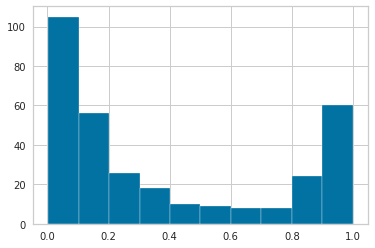

In [33]:
y_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_val  = roc_auc_score(y_test, y_proba)
print('Площадь ROC-кривой:',roc_auc_val)
plt.hist(y_proba)

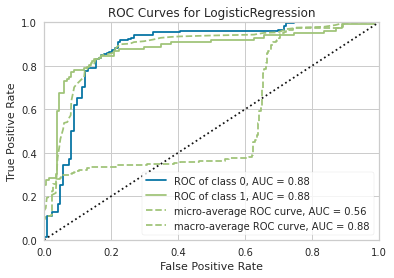

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LogisticRegression(C=2, penalty='l1', random_state=42,
                                    solver='liblinear'))

In [34]:
# построим ROC-кривую
roc_auc(randomized_search.best_estimator_.steps[1][1], 
        data_preprocessor.fit_transform(X_test), 
        y_test)

### Промежуточный вывод
ROC-AUC = 0.88. Модель работает хорошо, и намного лучше чем случайные предсказания.

Среди всех моделей, лучшей оказалась логистическая регрессия с l1 регуляризацией и сложностью С=2

## Анализ важности признаков

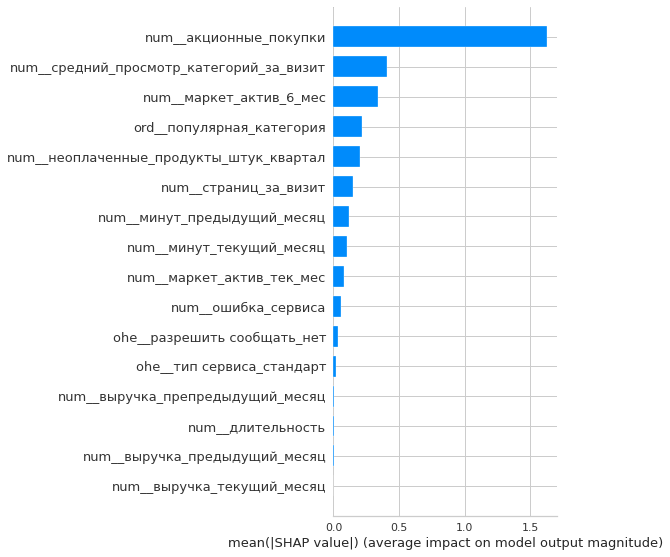

In [35]:
# Подготовим тренировочную и тестовые выборки c применением шага масштабирования из пайплайна.
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
# Сохраняем список с названиями столбцов
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
# Cформируем датасет с колонками после масштабирования и энкодинга и их названиями.
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2, feature_names=feature_names)
shap_values = explainer(X_test_2)

# визуализируем общий вклад признаков
shap.summary_plot(shap_values, X_train_2, plot_type='bar')

### Промежуточный вывод

Визуализировав общий вклад признаков, приходим к выводу: больше всего на модель оказывает влияние признак "акционные_покупки".

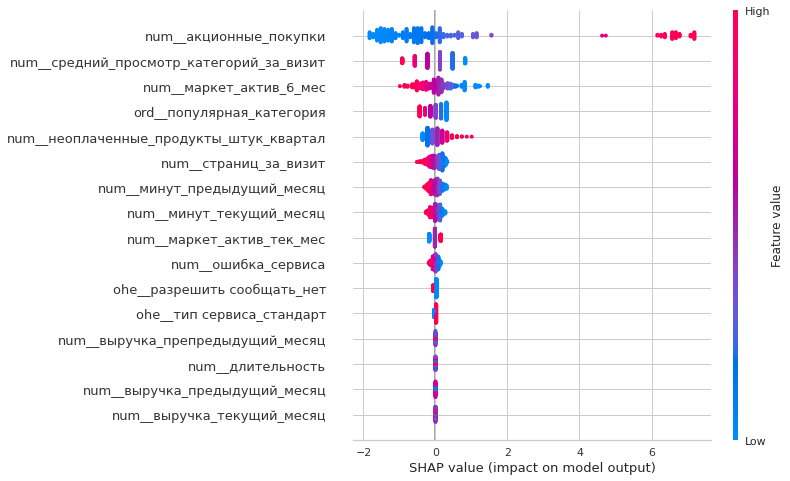

None

In [36]:
display(shap.plots.beeswarm(shap_values, max_display=16)) 

### Промежуточный вывод beeswarm

К сожалению вывода нет, так как у меня не получилось решить эту ошибку..

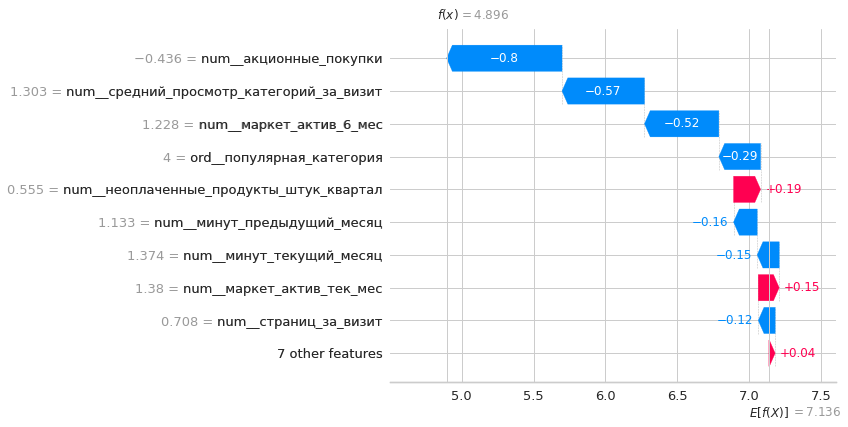

In [37]:
# визуализируtv индивидуальные SHAP-значения каждого наблюдения в датасете.
shap.plots.waterfall(shap_values[42])

### Промежуточный вывод по waterfall

Если я правильно понимаю, то клиенты, которые покупают по акции и просматривают много категорий покупают меньше, чем другие клиенты в среднем. То есть для удержания клиентов нам необходимо увеличить количество акций и маркетинговую активность.

### Вывод по анализу важности

Признак "Акционные покупки" оказывает отрицательное влияние на активность пользователей. Это может быть связано с тем, что пользователи, привлеченные рекламой и ожидающие скидок, теряют интерес, когда акция заканчивается.

Признак "Маркетинговая активность за последние 6 месяцев" положительно влияет на активность. Это означает, что пользователи, которые были активны в прошлом, с большей вероятностью остаются активными в будущем.

Рекомендации для увеличения активности пользователей:

~~ Развитие рекомендательной системы:~~

~~Вложить ресурсы в улучшение рекомендаций, чтобы пользователи, которые просто просматривают сайт, начали совершать покупки.~~ 

* Система скидок для постоянных пользователей:

Создать специальные акции и скидки для лояльных клиентов, чтобы удержать тех, кто активно реагирует на скидки.

## Сегментация покупателей

Нам необходимо используя результаты моделирования и данные о прибыльности покупателей провести сегментацию покупателей.

Будем сегментировать по признаку покупательской активности ориентируясь на показатели выручки за текущий месяц. Выберем клиентов, которые приносят выручку выше среднего и имеют высокую вероятность снижения активности.

Text(0.5, 1.0, 'Диаграмма рассеяния покупателей по выручке')

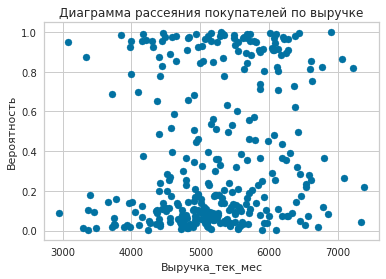

In [38]:
pred_df = X_test
pred_df['y_test'] = y_test 
pred_df['y_proba_1'] = y_proba
plt.scatter( pred_df['выручка_текущий_месяц'], pred_df['y_proba_1'])
plt.xlabel('Выручка_тек_мес')
plt.ylabel('Вероятность')
plt.title('Диаграмма рассеяния покупателей по выручке')

### Промежуточный вывод

По данным графика видно что большой сегмент покупателей, по которым есть большая доля вероятности снижения покупательской активности лежит в диапазоне от 3400 до 6600. За бОльшую вероятность примем значения предсказаний от 0.6.

Text(0.5, 1.0, 'Диаграмма рассеяния покупателей по выручке, отфильтрованная')

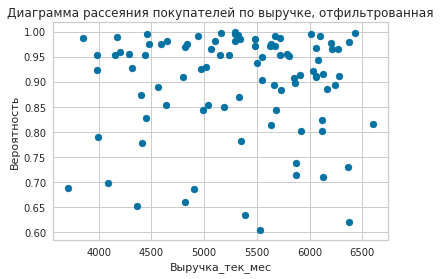

In [39]:
customers_df = pred_df.loc[(pred_df['y_proba_1'] > 0.6) & ((pred_df['выручка_текущий_месяц'] > 3400) & (pred_df['выручка_текущий_месяц'] < 6600))]
customers_df2 = pred_df.loc[(pred_df['y_proba_1'] < 0.6) & ((pred_df['выручка_текущий_месяц'] > 3400 )&(pred_df['выручка_текущий_месяц'] < 6600))]

plt.scatter(customers_df['выручка_текущий_месяц'], customers_df['y_proba_1'])
plt.xlabel('Выручка_тек_мес')
plt.ylabel('Вероятность')
plt.title('Диаграмма рассеяния покупателей по выручке, отфильтрованная')

In [40]:
#посмотрим сколько у нас клиентов,
# чья покупательская активность скорее всего будет снижаться
len(customers_df)

92

Посмотрим на корреляционные матрицы целевых и нецелевых пользователей:

In [41]:
interval_cols2 = [
    'маркет_актив_6_мес',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит'
    'страниц_за_визит',
    'ошибка_сервиса',
    'минут_предыдущий_месяц',
    'выручка_текущий_месяц'
]

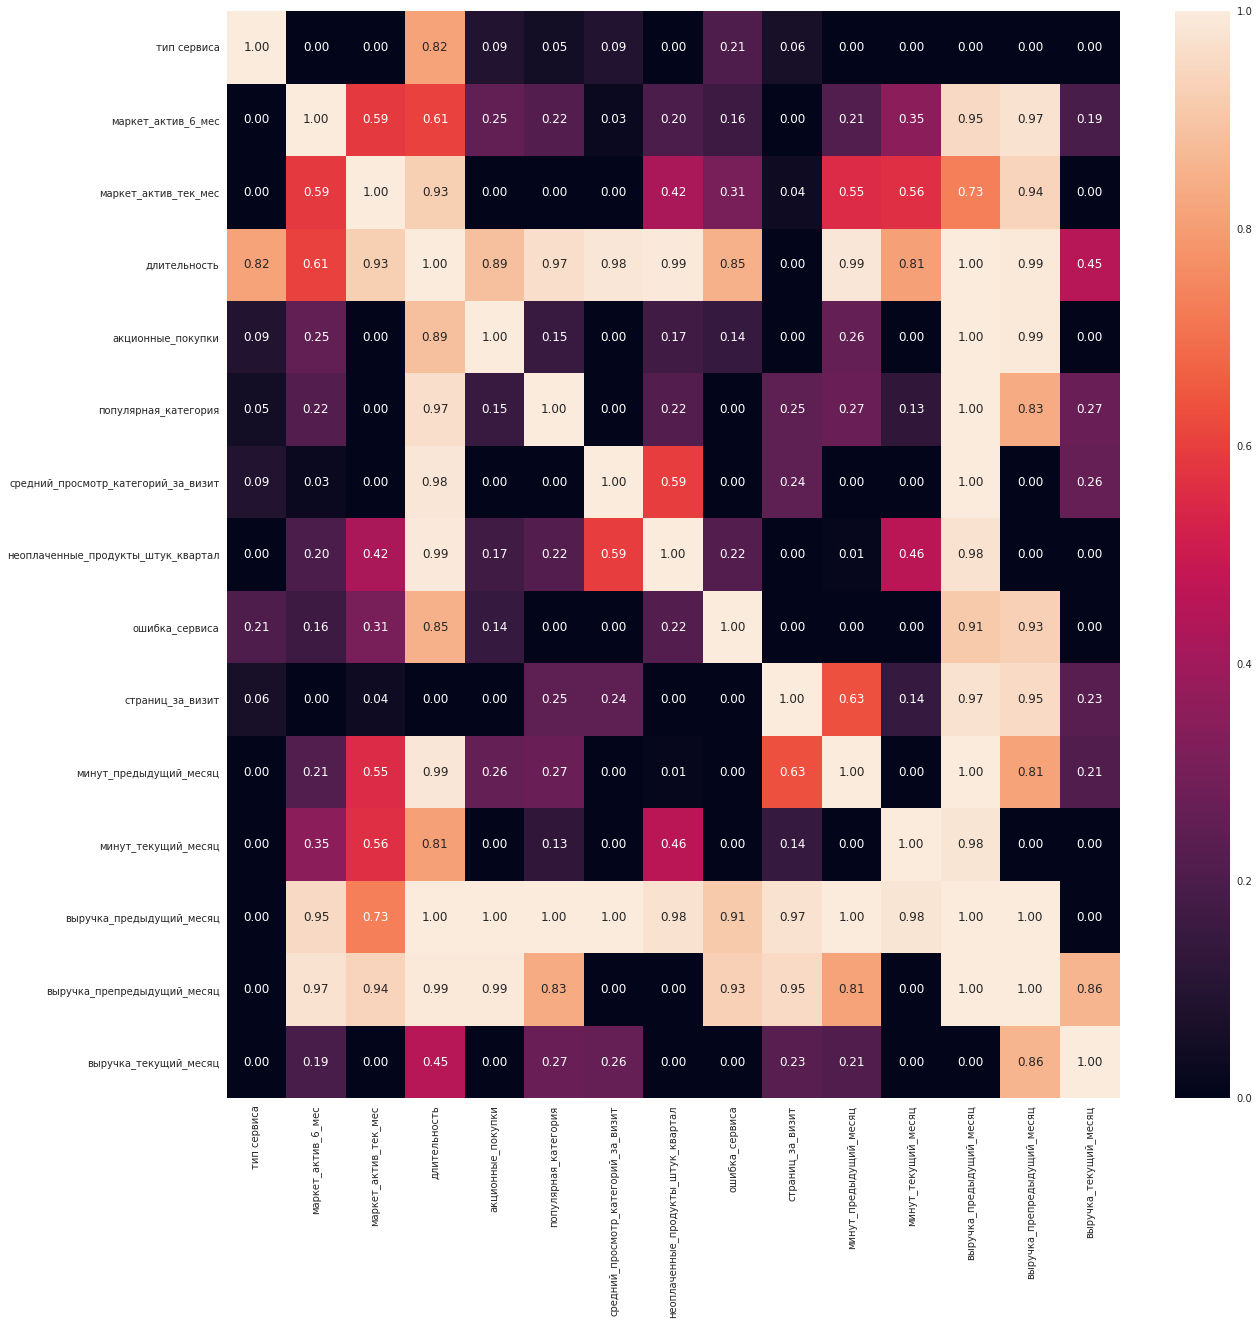

In [42]:
plt.figure(figsize=(20, 20))

sns.heatmap(
    customers_df.drop([ 'разрешить сообщать', 'y_test', 'y_proba_1'], axis=1).phik_matrix(
        interval_cols=interval_cols2
    ), annot=True, fmt='.2f'
)

plt.show()

Можно заметить, что на покупательскую активность таких пользователей, сильнее влияет количество страниц, которое они просматривают, а также количество времени, проведенного на сайте. Построим графики.

In [43]:
# Введем бинарный признак для графической аналитики
customers_df['y_pred'] = customers_df['y_proba_1'].apply(lambda x: 0 if x < 0.1 else 1)
customers_df2['y_pred'] = customers_df2['y_proba_1'].apply(lambda x: 0 if x < 0.1 else 1)

In [44]:
def plot_feature_relationship(data, col_name, plot_type='scatter', color='blue', ax=None, figsize=(10, 6)):
    """
    Функция для визуализации зависимости вероятности снижения активности 
    от признака
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_type == 'scatter':
        data.plot.scatter(
            ax=ax,
            x=col_name,
            y="y_proba_1",
            color=color,
            title=f'Зависимость вероятности снижения активности\nот {col_name}',
            xlabel=col_name,
            ylabel='Вероятность снижения активности'
        )
    elif plot_type == 'bar':
        pivot = data.pivot_table(index=col_name, values="y_proba_1", aggfunc='median')
        pivot.columns = ['median']
        pivot.sort_values(by='median', ascending=True, inplace=True)
        pivot.plot.barh(
            ax=ax,
            color=color,
            title=f'Зависимость вероятности снижения активности\nот {col_name}',
            xlabel='Медианная вероятность',
            ylabel=col_name
        )
       
    return ax

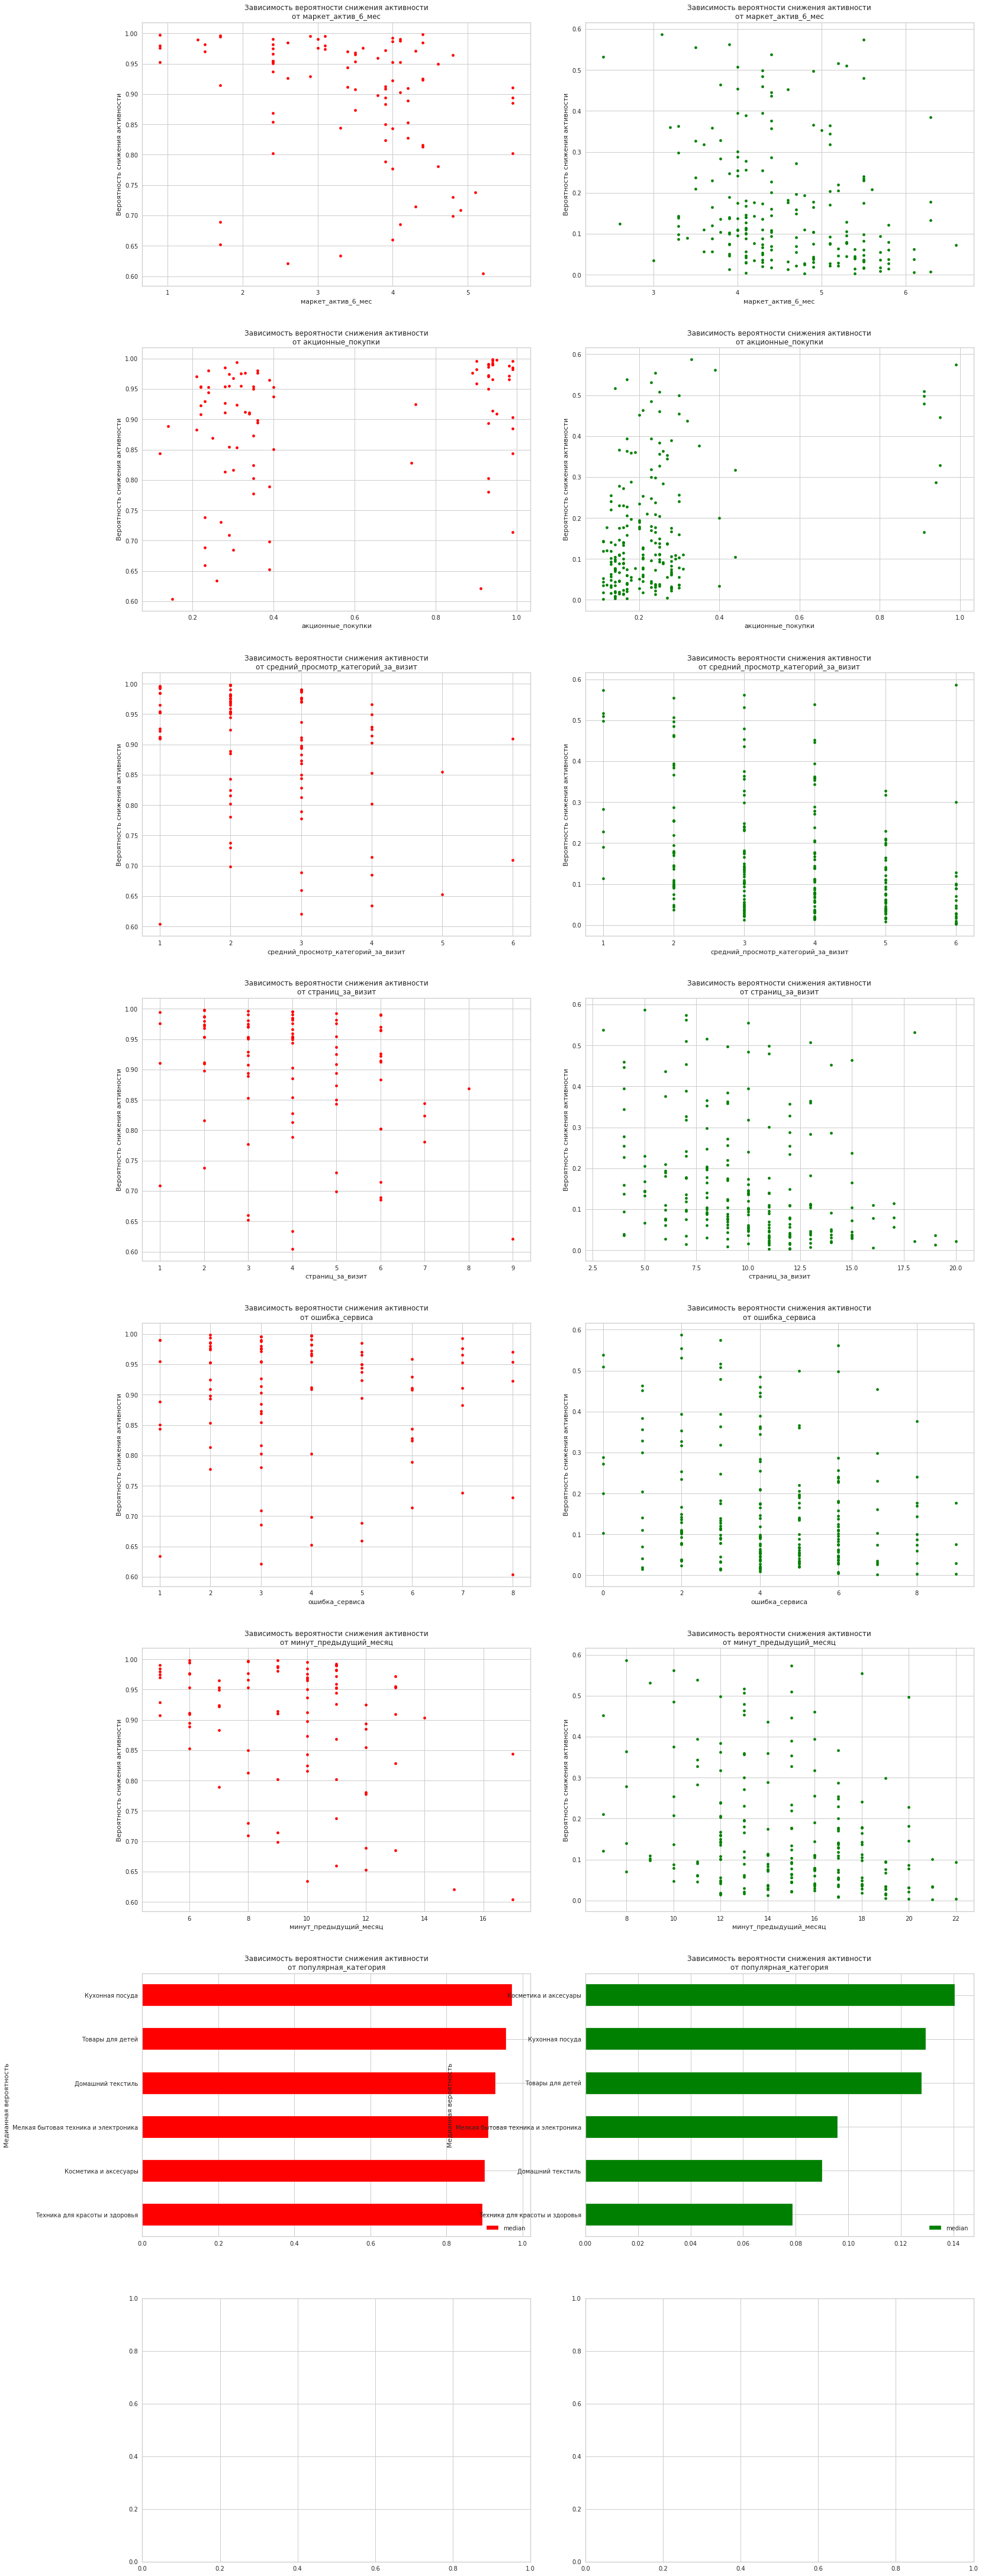

In [45]:
num_cols=['маркет_актив_6_мес','акционные_покупки','средний_просмотр_категорий_за_визит','страниц_за_визит','ошибка_сервиса','минут_предыдущий_месяц']
cat_cols=['популярная_категория']
# Создание фигуры и осей
fig, axes = plt.subplots(ncols=2, nrows=8, figsize=(10, 20))
fig.tight_layout()

# Построение графиков для числовых признаков
for i in range(len(num_cols)):
    plot_feature_relationship(customers_df, num_cols[i], plot_type='scatter', color='red', ax=axes[i, 0])
    plot_feature_relationship(customers_df2, num_cols[i], plot_type='scatter', color='green', ax=axes[i, 1])

# Построение графиков для категориальных признаков
for i in range(len(num_cols), len(num_cols) + len(cat_cols)):
    idx = i - len(num_cols)  # Корректный индекс для cat_cols
    plot_feature_relationship(customers_df, cat_cols[idx], plot_type='bar', color='red', ax=axes[i, 0])
    plot_feature_relationship(customers_df2, cat_cols[idx], plot_type='bar', color='green', ax=axes[i, 1])

# Настройка отступов
plt.subplots_adjust(right=2, top=3)
plt.show()

### Промежуточный вывод

* Наблюдения по целевому сегменту
По сравнению с остальными пользователями, в целевом сегменте наблюдаются следующие особенности:

- Маркетинговые взаимодействия:

Высокая вероятность потери клиента при большом количестве маркетинговых взаимодействий. Возможно, целевые пользователи негативно реагируют на навязчивую рекламу и звонки.

- Акционные покупки:

Большое количество акционных покупок часто связано со снижением активности в будущем. Это может указывать на пользователей, которые совершают покупки только во время акций и не возвращаются.

- Просмотр категорий и страниц:

Низкое количество просмотренных категорий и страниц за визит увеличивает вероятность потери клиента. Это может говорить о том, что пользователи быстро покидают сайт, если не находят подходящие товары с первого взгляда.

- Ошибки сервиса:

Наличие ошибок на сайте негативно влияет на удержание клиентов.

- Время на сайте:

Малое время, проведенное на сайте, способствует потере клиентов.

- Популярные категории:

Среди целевых клиентов наиболее популярны товары для детей, домашний текстиль и кухонная посуда.

- Неоплаченные товары:

Целевые клиенты редко оставляют товары в корзине без оплаты, что может указывать на их низкую склонность к спонтанным покупкам.

### Также сформируем рекомендацию для бизнеса.

* Маркетинговые взаимодействия:

Проводить маркетинговые кампании более ненавязчиво, чтобы не отпугнуть целевую аудиторию.

- Акции и скидки:

Не делать акции основным инструментом привлечения клиентов, так как они могут привлекать "одноразовых" покупателей, снижая качество аудитории.

- Рекомендации и ассортимент:

Развивать рекомендательную систему, чтобы стимулировать пользователей просматривать больше товаров и категорий.Побуждать пользователей исследовать другие категории, например, через персонализированные предложения.

~~Улучшение пользовательского опыта:~~

~~Минимизировать количество ошибок на сайте, чтобы повысить удовлетворенность клиентов.~~

- Фокус на популярные категории:

Уделить больше внимания товарам для дома (домашний текстиль, кухонная посуда), так как они наиболее популярны среди целевой аудитории.


## Общий вывод

### Цель исследования
Целью исследования была сегментация покупателей и разработка персонализированных предложений для предотвращения снижения их покупательской активности. Для этого мы провели анализ данных, построили модель машинного обучения и выявили ключевые факторы, влияющие на активность клиентов.

### Этапы исследования

#### Подготовка данных:

Были предоставлены данные о поведении покупателей на сайте, их покупательской активности, маркетинговых взаимодействиях, прибыльности и времени, проведенном на сайте.

Проведена предобработка данных: переименование столбцов, приведение типов, обработка пропусков и дубликатов, синтез новых признаков и устранение коррелирующих.

#### Анализ данных:

Проведен исследовательский и корреляционный анализ для выявления аномалий и ключевых моментов необходимх для цели работы.

Данные были подготовлены для машинного обучения, включая обработку целевого признака — уровня покупательской активности («снизилась» или «прежний уровень» заменено на 1 и 0 соответственно). Также были устранены кореллирующие.

#### Моделирование:

Для поиска наилучшей модели использовался инструмент RandomaziedSearch и с помощью пайлайнов был найден лучший вариант среди нескольких моделей(KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC).

Лучшей моделью оказалась Logistic Regression с метрикой ROC-AUC 0.89 на тренировочных данных и 0.88 на тестовых.

#### Интерпретация модели:

С помощью SHAP-анализа были выявлены ключевые признаки, влияющие на снижение активности:

* Высокое количество маркетинговых взаимодействий.

- Большое количество акционных покупок.

- Низкое количество просмотренных категорий и страниц за визит.

- Наличие ошибок на сайте.

- Малое время, проведенное на сайте.

- Также были выделены популярные категории среди целевых клиентов: товары для детей, домашний текстиль и кухонная посуда.

#### Рекомендации для бизнеса
На основе анализа данных и результатов моделирования будут предложены следующие рекомендации:

* Маркетинговые взаимодействия:

Проводить маркетинговые кампании более ненавязчиво, чтобы не отпугнуть целевую аудиторию.

- Акции и скидки:

Не делать акции основным инструментом привлечения клиентов, так как они могут привлекать "одноразовых" покупателей, снижая качество аудитории.

~~Рекомендательная система:

~~Вложить ресурсы в развитие рекомендательной системы, чтобы стимулировать пользователей просматривать больше товаров и категорий.~~

- Улучшение пользовательского опыта:

Минимизировать количество ошибок на сайте и улучшить навигацию для повышения удовлетворенности клиентов.

- Фокус на популярные категории:

Уделить больше внимания товарам для дома (домашний текстиль, кухонная посуда), так как они наиболее популярны среди целевой аудитории.

- Персонализированные предложения:

Разработать персонализированные предложения для сегментов с высокой вероятностью снижения активности, но высокой потенциальной прибылью.

#### Заключение
Проведенное исследование позволило не только выявить ключевые факторы, влияющие на снижение покупательской активности, но и предложить конкретные меры для удержания клиентов. Реализация рекомендаций поможет повысить лояльность целевой аудитории и увеличить прибыль компании.


